In [1]:
!pip install datasets transformers evaluate
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.1 MB/s eta 0:00:00


In [2]:
from torch.utils.data import Dataset
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from torch import nn
import torch
from transformers import AutoTokenizer


In [36]:
dataset = load_dataset("copenlu/answerable_tydiqa")

train_set = dataset["train"]
validation_set = dataset["validation"]

def get_answer_start(row):
  return row["annotations"]["answer_start"][0]

def get_answer(row):
  return row["annotations"]["answer_text"][0]

def get_document(row):
  return row["document_plaintext"]

def get_question(row):
  return row["question_text"]

def oracle(answer, document):
  return answer != "" and answer in document

def row_oracle(row):
  return oracle(get_answer(row), get_document(row))

def get_language(dataset, lang):
  return dataset.filter(lambda x: x["language"] == lang)#[row for row in dataset if row['language'] == lang]

In [4]:
train_arabic = get_language(train_set, "arabic")
val_arabic = get_language(validation_set, "arabic")

train_bengali = get_language(train_set, "bengali")
val_bengali = get_language(validation_set, "bengali")

train_indonesian = get_language(train_set, "indonesian")
val_indonesian = get_language(validation_set, "indonesian")

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

In [5]:
train_arabic_tt = train_arabic.train_test_split(test_size=0.2)
train_bengali_tt = train_bengali.train_test_split(test_size=0.2)
train_indonesian_tt = train_indonesian.train_test_split(test_size=0.2)

In [60]:
MODEL = "bert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [67]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [111]:
bengali_removal_list = list(set(stopwords.words('bengali')))

def remove_stop_words(sentence, stopwords):
  words = sentence.split()
  filtered_words = [word for word in words if word not in stopwords]
  return ' '.join(filtered_words)

def preprocess(row):
    document = remove_stop_words(get_document(row), bengali_removal_list)
    question = remove_stop_words(get_question(row), bengali_removal_list)

    #row["label"] = int(row_oracle(row))
    return tokenizer(question + ' <SEP> ' + document, truncation=True)

In [85]:
tokenized_train_bn = train_bengali_tt.map(preprocess, remove_columns=train_bengali_tt["train"].column_names)

Map:   0%|          | 0/3823 [00:00<?, ? examples/s]

Map:   0%|          | 0/956 [00:00<?, ? examples/s]

In [86]:
for row in tokenized_train_bn["train"]:
  if len(row["input_ids"]) > 512:
    print(len(row["input_ids"]))

In [55]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [47]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):

    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)

In [48]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [126]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
from huggingface_hub import notebook_login

notebook_login()

In [57]:
tokenized_train_bn

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 3823
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 956
    })
})

In [87]:
training_args = TrainingArguments(

    output_dir="my_awesome_clas_model",

    learning_rate=2e-5,

    per_device_train_batch_size=16,

    per_device_eval_batch_size=16,

    num_train_epochs=2,

    weight_decay=0.01,

    evaluation_strategy="epoch",

    save_strategy="epoch",

    load_best_model_at_end=True,

    push_to_hub=True,

)

trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=tokenized_train_bn["train"],

    eval_dataset=tokenized_train_bn["test"],

    tokenizer=tokenizer,

    data_collator=data_collator,

    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.433035,0.811715
2,No log,0.364054,0.855649


TrainOutput(global_step=478, training_loss=0.4386754375122581, metrics={'train_runtime': 852.758, 'train_samples_per_second': 8.966, 'train_steps_per_second': 0.561, 'total_flos': 1888972933075200.0, 'train_loss': 0.4386754375122581, 'epoch': 2.0})

In [112]:
val_bengali_processed = val_bengali.map(preprocess, remove_columns=val_bengali.column_names)

Map:   0%|          | 0/224 [00:00<?, ? examples/s]

In [114]:
tokenizer = AutoTokenizer.from_pretrained("Axel-0087/my_awesome_clas_model")


model = AutoModelForSequenceClassification.from_pretrained("Axel-0087/my_awesome_clas_model")

In [119]:
preds = []
labels = []

for row in val_bengali:
  document = remove_stop_words(get_document(row), bengali_removal_list)
  question = remove_stop_words(get_question(row), bengali_removal_list)

  text = question + ' <SEP> ' + document

  inputs = tokenizer(text, return_tensors="pt", truncation=True)
  with torch.no_grad():
      logits = model(**inputs).logits
      pred = np.argmax(logits, axis=1)
      preds.append(pred)

  labels.append(row_oracle(row))

In [121]:
accuracy.compute(predictions=preds, references=labels)

{'accuracy': 0.8080357142857143}

In [125]:
!pip install bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 12.9 MB/s eta 0:00:00


In [132]:
from transformers import AutoModel
from bertviz import model_view

row = val_bengali[0]

document = remove_stop_words(get_document(row), bengali_removal_list)
question = remove_stop_words(get_question(row), bengali_removal_list)
text = question + ' <SEP> ' + document

model = AutoModel.from_pretrained("Axel-0087/my_awesome_clas_model", output_attentions=True)  # Configure model to return attention values
tokenizer = AutoTokenizer.from_pretrained("Axel-0087/my_awesome_clas_model")

inputs = tokenizer(text, return_tensors="pt", truncation=True)

outputs = model(**inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
input_ids = inputs["input_ids"]
print(input_ids[0])
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

tensor([   101,  87599,  34388,    972,  77595,  12079,  38695,  21790,  89030,
           972,  16166,  15002,  29806,  40102,  30510,  11199, 107203,    950,
         56173,  18262,  24758,  59136,    939,  77045,  32437,    978,  38833,
         96397,  13542,  15215,  40704,    971,  17460,  50782,  22335,  21790,
         83924,  11128,    978,  38833,  96397,  11737,    136,    133,  23056,
         11127,    135,    965,  62753, 111240,  79385,    965,  11128,  29806,
         15010,    963, 111238,  79622,  11128,  83011,    117,    950,  56173,
         18262,  24758,  59136,    939,  77045,  32437,  45002,  23538,  23538,
         15375,    948,  43016,    955,  11128, 106203,    969,  40102,  61596,
           948,  64437,  12235,  39893,  82742,    972,  16166,  15002,  29806,
         40102,  41026,  15002,  26796,    978, 111240,  15002,  52800,    974,
         74080,  11128,  38833,  11199, 105234,  46121,    920,    978,  38833,
         96397,  13542,  15215,  40704, 

In [134]:
output_attentions_all = torch.stack(attention)

In [136]:
output_attentions_all.shape

torch.Size([12, 1, 12, 295, 295])

In [137]:
import matplotlib.pyplot as plt

def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))

        ax.set_xticklabels(tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

<ipython-input-137-b580e6becf14>:22: UserWarning: Glyph 2474 (\N{BENGALI LETTER PA}) missing from current font.
  plt.tight_layout()
<ipython-input-137-b580e6becf14>:22: UserWarning: Matplotlib currently does not support Bengali natively.
  plt.tight_layout()
<ipython-input-137-b580e6becf14>:22: UserWarning: Glyph 2486 (\N{BENGALI LETTER SHA}) missing from current font.
  plt.tight_layout()
<ipython-input-137-b580e6becf14>:22: UserWarning: Glyph 2509 (\N{BENGALI SIGN VIRAMA}) missing from current font.
  plt.tight_layout()
<ipython-input-137-b580e6becf14>:22: UserWarning: Glyph 2458 (\N{BENGALI LETTER CA}) missing from current font.
  plt.tight_layout()
<ipython-input-137-b580e6becf14>:22: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  plt.tight_layout()
<ipython-input-137-b580e6becf14>:22: UserWarning: Glyph 2478 (\N{BENGALI LETTER MA}) missing from current font.
  plt.tight_layout()
<ipython-input-137-b580e6becf14>:22: UserWarning: Glyph 2477 (\N{BENG

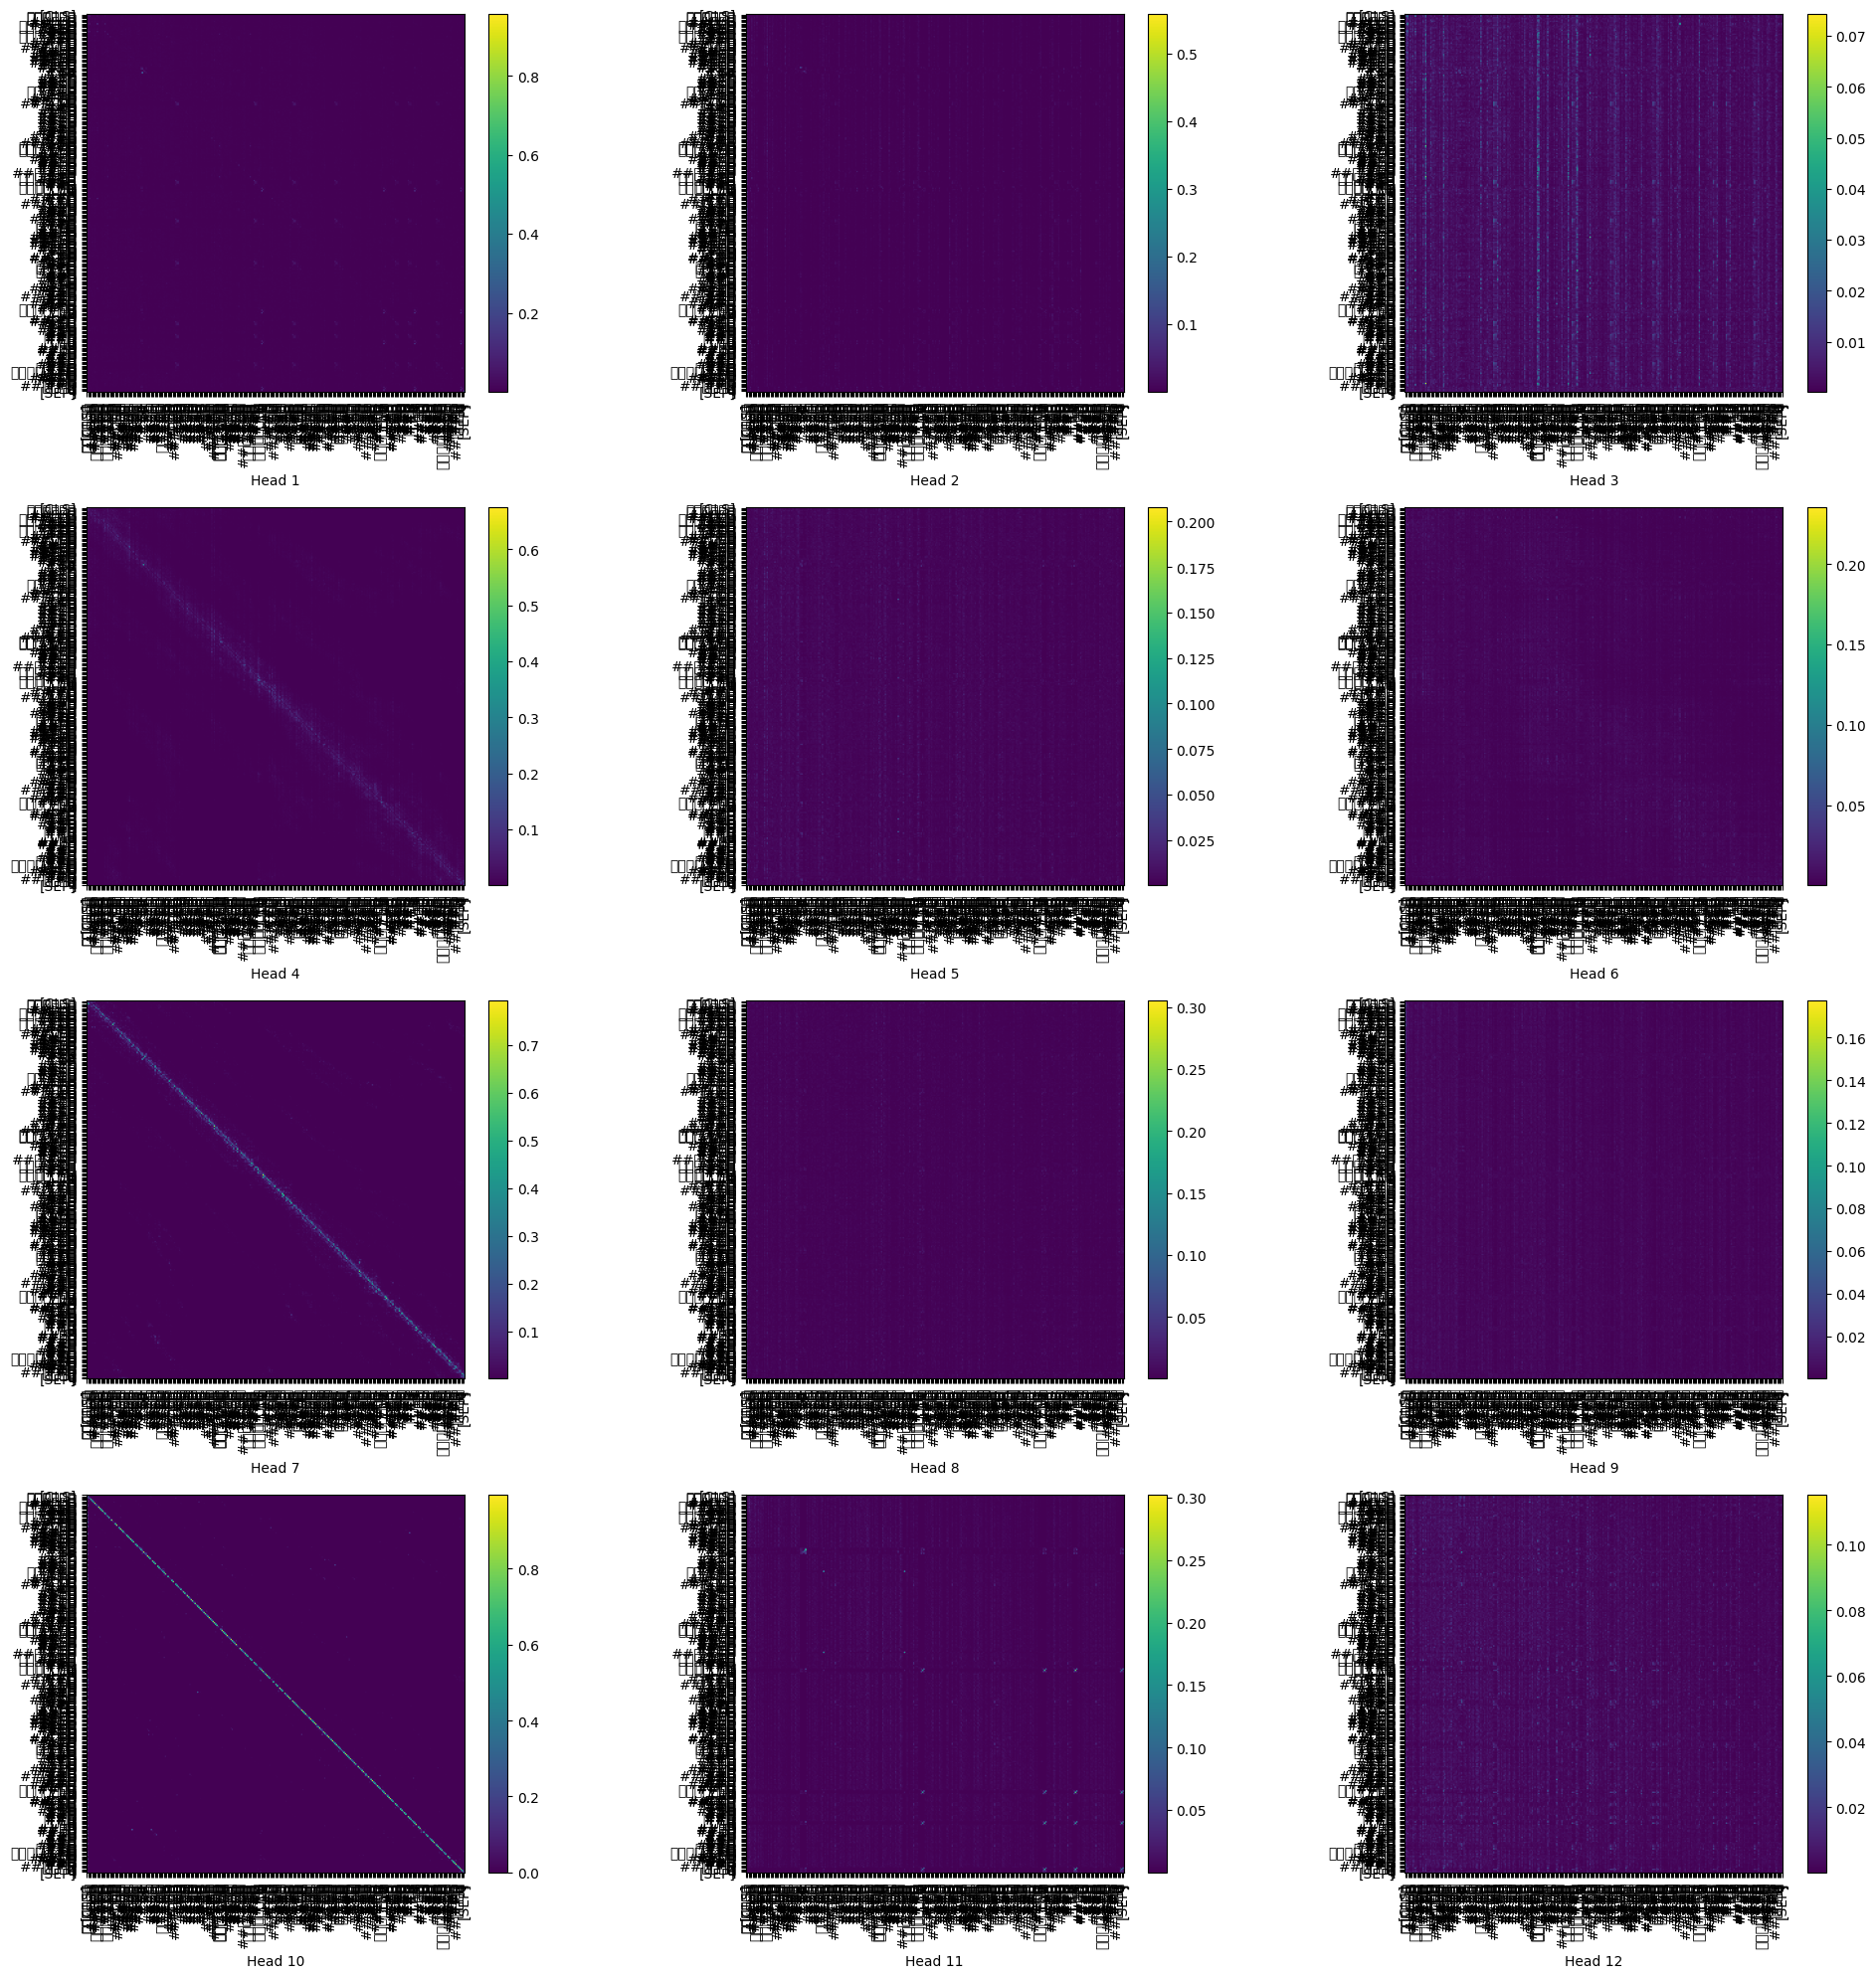

In [138]:
visualize_token2token_scores(output_attentions_all[0].squeeze().detach().cpu().numpy())